# YYYYMMDD Name

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Utility functions

In [2]:
def plot(camera_position, orientation_euler, intersection_point = None):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # plot xyz axes
    ax.plot([0, 1], [0, 0], [0, 0], c='r')
    ax.plot([0, 0], [0, 1], [0, 0], c='g')
    ax.plot([0, 0], [0, 0], [0, 1], c='b')

    # plot camera position
    ax.scatter(*camera_position, s=20, c='red')
    # plot projection of the camera position on the XY plane
    ax.scatter(camera_position[0], camera_position[1], 0, marker='x', c='k', alpha=0.2)
    # plot line between camera position and above projection
    ax.plot([camera_position[0], camera_position[0]], [camera_position[1], camera_position[1]], [0, camera_position[2]], ls='--', c='k', alpha=0.2)

    # plot viewing vector
    r = R.from_euler("xyz", orientation_euler, degrees=True)
    line = np.zeros((2, 3))
    line[1, 2] = 1
    line_rot = r.apply(line)
    line_plot = line_rot + camera_position
    ax.plot(line_plot[:, 0], line_plot[:, 1], line_plot[:, 2], lw=4, c='y')

    # plot intersection point
    if intersection_point is not None:
        ax.scatter(*intersection_point, marker='x', c='b', s=20)

    # set attributs
    ax.set(title='', xlim=(0, 3), ylim=(3, 0), zlim=(0, 3),
           xlabel='X', ylabel='Y', zlabel='Z',
           xticks=range(0, 5), yticks=range(0, 5), zticks=range(0, 5))
    plt.show()

# Simple camera

In [3]:
# camera
position = np.array([2, 1, 3])
orientation_euler = np.array([-180, 0, 0]) # rotation in degrees, camera is pointing in the local +Z direction


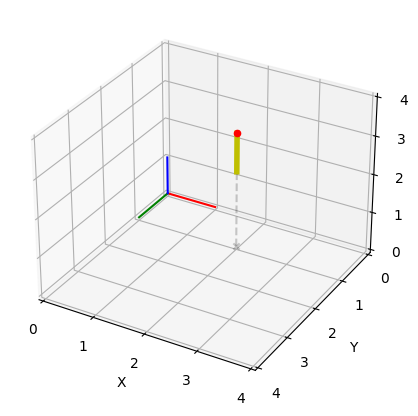

In [4]:
plot(position, orientation_euler)

# 1. Get intersection

In [8]:
def get_intersection_xy(position: np.ndarray, orientation_euler: np.ndarray)-> np.ndarray:
    rotation_matrix = R.from_euler("xyz", orientation_euler, degrees=True).as_matrix()

    viewing_direction = np.dot(rotation_matrix, np.array([0, 0, 1]))

    t = position[2] / viewing_direction[2]
    intersection_point = position + t * viewing_direction

    return intersection_point[:2]

In [9]:
intersection_point = get_intersection_xy(position, orientation_euler)
intersection_point

array([2., 1.])

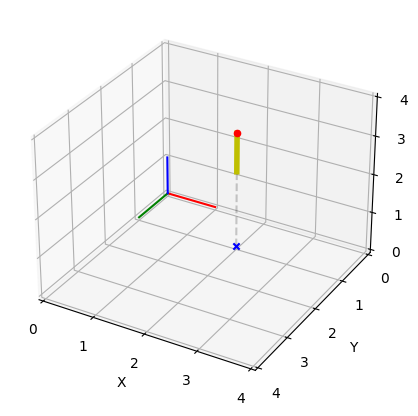

In [10]:
plot(position, orientation_euler, intersection_point)

In [11]:
def test_camera_pointing_downward():
    position = np.array([0, 0, 5])
    orientation_euler = np.array([-180, 0, 0])

    intersection = get_intersection_xy(position, orientation_euler)

    expected_intersection = np.array([0, 0])
    assert np.allclose(intersection, expected_intersection), f"Expected intersection at {expected_intersection}, got {intersection}"

def test_camera_pointing_at_angle():
    position = np.array([0, 0, 5])
    orientation_euler = np.array([-180, -20, 0])

    intersection = get_intersection_xy(position, orientation_euler)

    assert intersection[0] > 0 and np.allclose(intersection[1], 0), "Intersection should be in positive X direction from the origin"

In [12]:
test_camera_pointing_downward()

In [13]:
test_camera_pointing_at_angle()

AssertionError: Intersection should be in positive X direction from the origin

# 2. Frame camera

Now, instead of assuming camera is a single point, we would like to modify it into a 2D-sensor. To make it simple, we use the 4 corners of the frame to represent. Now based on the previous functions, we would like to create a function that can find the intersection of the frame to planes.